## Interacions
Estraggo le interacions dal dataset dei commenti 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data=pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_comments.csv',encoding='ISO-8859-1')
post_count = data.groupby('post_id')['from_id'].nunique().reset_index(name='post_size')
post_from_count = data.groupby(['post_id', 'from_id']).size().reset_index(name='interaction_len')
joined_df = pd.merge(post_count, post_from_count, on='post_id', how='inner')
joined_df[['post_size','interaction_len']].to_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_interactions.csv')

## Outreach for each post

I successivi blocchi di codice consentono di fare un confronto tra la len dell'interazione e la size dell'outreach di una pagina misurata come Lurkers in quel momento.

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np

In [98]:
posts = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_posts.csv',usecols=['created_time', 'page_id', 'post_id'],encoding='ISO-8859-1')
likes = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_likes.csv', usecols=['from_id', 'post_id'], encoding='ISO-8859-1')

Salvo per ciascuna pagine la serie storica dei Lurkers, ovvero il numero di utenti univoci che ha lasciato like a un qualsiasi post della pagina.

In [42]:
folder_path = '/home/jacoponudo/Documents/Size_effects/DATA/page_size/'
dataframes = []
for page_id in tqdm(posts['page_id'].unique()):
    page_posts = posts[posts['page_id'] == page_id]
    page_likes = likes[likes['post_id'].isin(page_posts['post_id'].unique())]

    complete_page_likes = pd.merge(page_posts, page_likes, on='post_id', how='right')
    complete_page_likes['created_time'] = pd.to_datetime(complete_page_likes['created_time'])
    complete_page_likes.set_index('created_time', inplace=True)

    weekly_unique_users = complete_page_likes['from_id'].resample('W').nunique()
    monthly_moving_avg = weekly_unique_users.rolling(window=4).mean()
    
    monthly_avg_df = pd.DataFrame({
        'Date': monthly_moving_avg.index,
        'Monthly Moving Average': monthly_moving_avg.values
    }).dropna() 
    monthly_avg_df.to_csv(f'{folder_path}/{page_id}_monthly_moving_avg.csv', index=False)

    monthly_avg_df.insert(2, 'page_id', page_id)
    dataframes.append(monthly_avg_df)

outreach = pd.concat(dataframes, ignore_index=True)

output_file = f'{folder_path}/all_outreach_pages.csv'
outreach.to_csv(output_file, index=False)

print(f"File salvato in: {output_file}")


100%|██████████| 117/117 [08:13<00:00,  4.22s/it]


In [211]:

folder_path = '/home/jacoponudo/Documents/Size_effects/DATA/page_size/'
dataframes = []
for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith('_monthly_moving_avg.csv'):
        page_id = filename.split('_')[0]  # Estrae page_id dal nome del file
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        df.insert(2, 'page_id', page_id)
        dataframes.append(df)
outreach = pd.concat(dataframes, ignore_index=True)
output_file = '/home/jacoponudo/Documents/Size_effects/DATA/page_size/all_outreach_pages.csv'
outreach.to_csv(output_file, index=False)


100%|██████████| 118/118 [00:00<00:00, 1367.47it/s]
/tmp/ipykernel_47432/501097947.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outreach = pd.concat(dataframes, ignore_index=True)


Puliamo la ram da tutti i file in memoria.

In [2]:
import gc
def clear_all():
    for name in dir():
        if not name.startswith('_'):
            del globals()[name]
    gc.collect()

# Pulisci la RAM da tutte le variabili
clear_all()

Per ogni interazione, calcolo quanto dura (interaction len) e dove avviene (page_id) e quando è iniziata (created_time), e qual'era il valore di Luckers sulla pagina su cui avviene in quel momento.

In [95]:
comments = pd.read_csv('/home/jacoponudo/Documents/Size_effects/DATA/sample_comments.csv',encoding='ISO-8859-1',usecols=['from_id', 'post_id'])
interactions = comments.groupby(['from_id', 'post_id']).size().reset_index(name='interaction_len')
del comments
gc.collect()



3297

Interpolazione dell'outreach di ogni post.

In [82]:

outreach_values = []
for idx, post in tqdm(posts.iterrows(), total=posts.shape[0]):
    page_id = post['page_id']
    outreach = outreachs[outreachs['page_id'] == int(page_id)].copy()
    
    # Estrai la data di creazione del post e convertila in formato datetime
    target_date = pd.to_datetime(post['created_time'])
    
    # Filtra le righe precedenti alla data di creazione del post
    previous_date_row = outreach[outreach['Date'] < target_date]
    
    # Se esistono righe precedenti, ottieni il valore della media mobile
    if not previous_date_row.empty:
        monthly_moving_avg = previous_date_row.loc[previous_date_row['Date'].idxmax()]['Monthly Moving Average']
    else:
        monthly_moving_avg = None  # Assegna None se non ci sono righe precedenti
    
    # Aggiungi il valore di outreach alla lista
    outreach_values.append(monthly_moving_avg)

# Aggiungi la nuova colonna 'outreach' al DataFrame 'posts'
posts['outreach'] = outreach_values


100%|██████████| 1482309/1482309 [26:27<00:00, 933.75it/s] 


In [ ]:
interactions_selected = interactions[['interaction_len', 'post_id']]
interactions_selected['alpha'] = (interactions['interaction_len'] < 2)
posts_selected = posts[['post_id', 'outreach']]

## Plot interacion len VS outreach

In [116]:


merged_df = pd.merge(interactions_selected, posts_selected, on='post_id', how='inner')
plt.figure(figsize=(10, 6))
plt.scatter( merged_df['outreach'],merged_df['interaction_len'], color='blue', alpha=0.7)
plt.title('Interaction Length vs Outreach')
plt.xlabel('Interaction Length')
plt.ylabel('Outreach')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()


/home/jacoponudo/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


OverflowError: Exceeded cell block limit in Agg.  Please set the value of rcParams['agg.path.chunksize'], (currently 0) to be greater than 100 or increase the path simplification threshold(rcParams['path.simplify_threshold'] = 0.111111111111 by default and path.simplify_threshold = 0.111111111111 on the input).

<Figure size 1000x600 with 1 Axes>

## Plot Alpha VS outreach

/home/jacoponudo/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_59722/3670521183.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  outreach_alpha_mean = merged_df.groupby('outreach_class')['alpha'].mean()


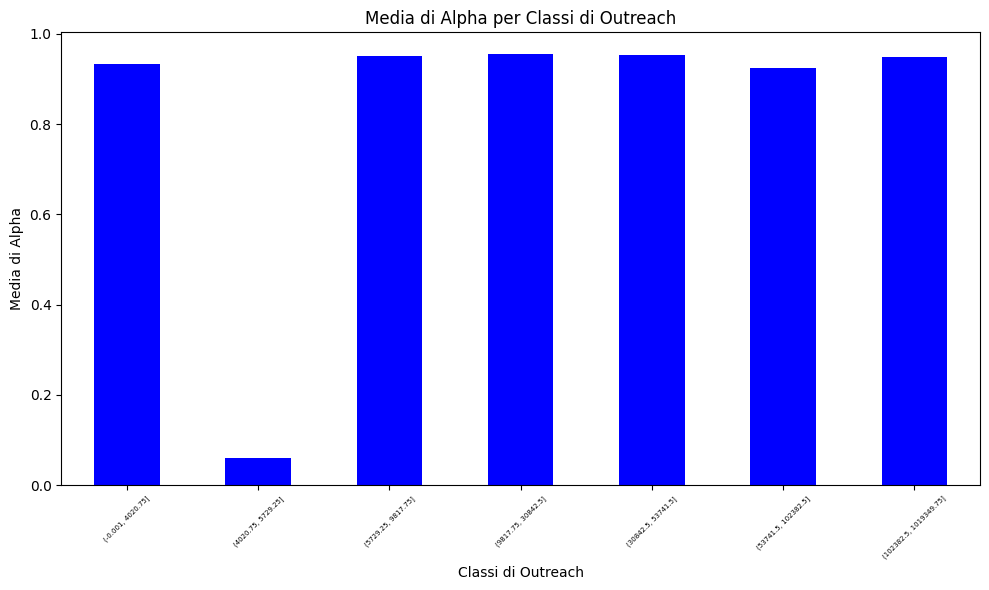

In [143]:
merged_df['log_outreach'] = np.log(merged_df['outreach'])
merged_df = merged_df.dropna(subset=['log_outreach'])  # Drop rows where log_outreach is NaN

merged_df['outreach_class'] = pd.qcut(merged_df['outreach'], q=10, duplicates='drop')
outreach_alpha_mean = merged_df.groupby('outreach_class')['alpha'].mean()
plt.figure(figsize=(10, 6))
outreach_alpha_mean.plot(kind='bar', color='blue')
plt.title('Media di Alpha per Classi di Outreach')
plt.xlabel('Classi di Outreach')
plt.ylabel('Media di Alpha')
plt.xticks(rotation=45,fontsize=5)
plt.tight_layout()
plt.show()


In [134]:
filtered_df = merged_df[(merged_df['outreach'] <5729) & (merged_df['outreach'] >4020)]
np.mean(filtered_df['interaction_len']==1)

np.float64(0.9357654461605245)